In [1]:
from datasets import load_dataset
import IPython.display as ipd
import numpy as np
from whisper_finetune.data.utils import inverse_mel_to_audio

/home/kenfus/miniconda3/envs/whisper_finetune/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import librosa
y, sr = librosa.load("Therapeutin A 5.m4a", sr=None)  # y is the audio signal, sr is the sampling rate

/tmp/ipykernel_4018/341117338.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load("Therapeutin A 5.m4a", sr=None)  # y is the audio signal, sr is the sampling rate
/home/kenfus/miniconda3/envs/whisper_finetune/lib/python3.9/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [3]:
y = librosa.resample(y, orig_sr=sr, target_sr=16000)

In [4]:
y.shape

(117696,)

In [ ]:

import matplotlib.pyplot as plt

In [ ]:
from librosa.feature import melspectrogram

In [127]:
# 2. STFT parameters
n_fft      = 2048       # ↪️ window size (in samples) for the FFT
win_length = 2048       # ↪️ length of the analysis window
hop_length = 512        # ↪️ hop between frames; smaller → smoother time resolution
window     = 'hann'     # ↪️ analysis window shape

# 3. Compute power spectrogram
S = librosa.stft(
    y,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window,
    center=True,
    pad_mode='reflect'
)
S_power = np.abs(S)**2    # ↪️ power spectrogram

# 4. Mel filterbank parameters
n_mels = 128              # ↪️ number of mel bands (higher → finer freq detail)
fmin   = 20               # ↪️ lowest frequency (Hz)
fmax   = sr // 2          # ↪️ highest frequency (Hz), typically Nyquist

In [152]:
M = melspectrogram(
    S=S_power,
    sr=sr,
    n_mels=n_mels,
    fmin=fmin,
    fmax=fmax,
    norm='slaney',         # ↪️ “slaney” scaling of filters
    htk=True               # ↪️ use HTK mel formula (common in speech)
)

log_mel_lib = librosa.power_to_db(
    M,
    ref=np.max,            # ↪️ reference level for 0 dB
    amin=1e-10,            # ↪️ clamp tiny values to avoid log(0)
    top_db=80              # ↪️ dynamic range in dB
)

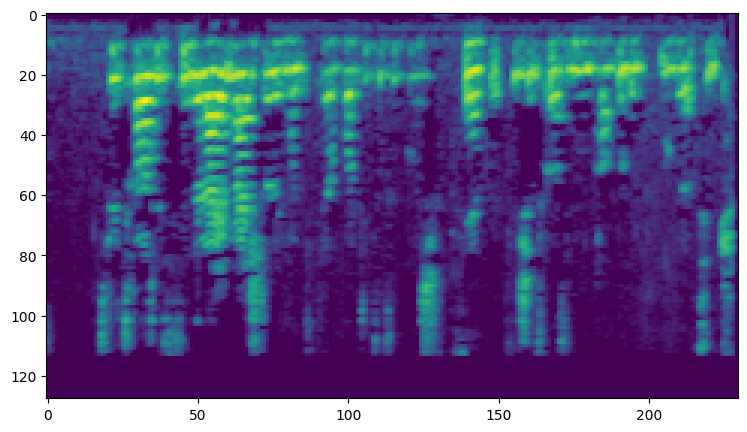

In [153]:
plt.figure(figsize=(10, 5))  # Width, height in inches
plt.imshow(log_mel_lib)
plt.show()

In [154]:
# 1. If you logged your mel: invert dB → power
M_recovered = librosa.db_to_power(log_mel_lib, ref=1.0)

# 2. Griffin–Lim / pseudo-inverse parameters
y_hat = librosa.feature.inverse.mel_to_audio(
    M_recovered,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window,
    center=True,
    pad_mode='reflect',
    power=2.0,            # ↪️ must match the power used above
    n_iter=200,           # ↪️ number of Griffin–Lim iterations (default=32)
)


In [190]:
# Librosa
display(Audio(y_hat, rate=16_000))

In [231]:
from whisper.audio import log_mel_spectrogram, N_FFT
N_MELS = 128
import torch

def inverse_whisper_log_mel(
    log_mel: torch.Tensor,
    sr: int = 16000,
    n_fft: int = N_FFT,
    hop_length: int = 160,
    win_length: int = 400,
    n_iter: int = 200,
) -> np.ndarray:
    # Invert dB compression: 10 * log10(mel) → power mel
    log_power = log_mel.detach().cpu().numpy() * 4.0 - 4.0
    M = np.power(10.0, log_power)  # power mel spectrogram

    # Invert mel → waveform via Griffin–Lim
    y = librosa.feature.inverse.mel_to_audio(
        M,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        n_iter=n_iter,
    )

    return y


In [187]:
whisper_log_mel = log_mel_spectrogram(y, n_mels=128)

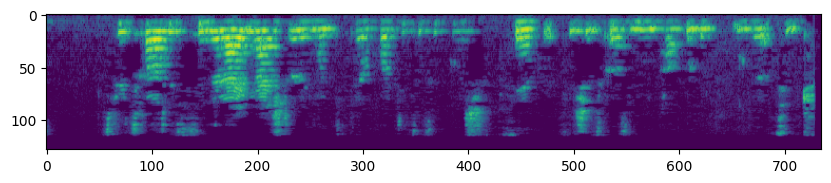

In [188]:
plt.figure(figsize=(10, 4))
plt.imshow(whisper_log_mel.numpy())

In [189]:
inverse_whisper = inverse_whisper_log_mel(whisper_log_mel)
display(Audio(inverse_whisper, rate=16_000))

In [276]:
import json, torch, whisper, torchaudio, matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple

# --- your two classes --------------------------------------------------------
import torch.nn as nn


class DropRidges(nn.Module):
    def __init__(self, knee_db: float, max_drop_db: float):
        super().__init__()
        self.knee = knee_db
        self.max_drop_db = max_drop_db           # <- now stored inside

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        floor  = x.quantile(0.1, dim=0, keepdim=True)        # (1,T)
        excess = torch.relu(x - (floor + self.knee))
        if excess.max() > 0:
            drop = excess / (excess.max() + 1e-9) * self.max_drop_db
            x = x - drop
        return x


class RaiseFloor(nn.Module):
    def __init__(self, target_floor: torch.Tensor, jitter_db: float = 2.0):
        super().__init__()
        self.register_buffer("target", target_floor)          # (80,)
        self.jitter = jitter_db

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gap     = (self.target.view(-1, 1) - x).clamp_min(0.) # lift only up
        jitter  = torch.randn_like(gap) * self.jitter
        return x + (gap + jitter).clamp_min(0.0)
    
def whisper_log_mel(path: str) -> torch.Tensor:
    wav = whisper.audio.load_audio(path)       # auto mono + 16 kHz
    mel = whisper.audio.log_mel_spectrogram(wav, n_mels=N_MELS)    # (1, 80, T)
    return mel.squeeze(0)                           # (80, T)

import torch, torchaudio
vad_model, utils = torch.hub.load(
        repo_or_dir='snakers4/silero-vad', model='silero_vad', trust_repo=True)
(get_speech_timestamps, _, read_audio, _, _) = utils

def floor_and_snr_vad(path:str) -> tuple[torch.Tensor,float]:
    """Return (per-mel noise floor, SNR-dB) for an audio file."""
    wav = whisper.audio.load_audio(path)          # mono/16 kHz float32
    mel = whisper_log_mel(path).squeeze(0)    # (80,T)
    # --- use VAD on raw waveform (10 ms hop) -----------------
    # get_speech_ts returns speech intervals in samples @16 kHz
    speech_ts = get_speech_timestamps(wav, vad_model, sampling_rate=16_000)
    print(speech_ts)
    # Create mask over mel frames
    hop = 160                      # Whisper hop 160 samples = 10 ms
    T   = mel.shape[1]
    speech_mask = torch.zeros(T, dtype=torch.bool)
    for seg in speech_ts:
        s = seg['start'] // hop
        e = seg['end']   // hop + 1
        speech_mask[s:e] = True
    noise_mask = ~speech_mask

    floor = mel[:, noise_mask].median(dim=1).values          # (80,)
    # speech level = 95-th percentile of speech frames
    speech_peak = mel[:, speech_mask].mean(0).quantile(0.95)
    snr = (speech_peak - floor.mean()).item()
    return floor, snr


Using cache found in /home/kenfus/.cache/torch/hub/snakers4_silero-vad_master


In [277]:

# %% pick your files ----------------------------------------------------------
clean_file    = "Therapeut B 3.m4a"     # << replace with your paths
degraded_file = "Therapeutin A 5.m4a"  # << replace with your paths

clean_mel  = whisper_log_mel(clean_file)
degrad_mel = whisper_log_mel(degraded_file)

# %% analyse ------------------------------------------------------------------
floor_clean,  snr_clean  = floor_and_snr_vad(clean_file)
floor_degrad, snr_degrad = floor_and_snr_vad(degraded_file)

[{'start': 2592, 'end': 29664}, {'start': 31264, 'end': 53728}, {'start': 55840, 'end': 76256}, {'start': 88096, 'end': 99808}, {'start': 102944, 'end': 114656}, {'start': 116768, 'end': 144864}, {'start': 146464, 'end': 154592}, {'start': 158752, 'end': 178144}]
[{'start': 10272, 'end': 45024}, {'start': 46624, 'end': 59360}, {'start': 61472, 'end': 67040}, {'start': 70688, 'end': 117696}]


In [303]:
snr_clean

0.9246460199356079

In [279]:
max_drop_db = max(snr_clean - snr_degrad, 0.0)   # <-- THIS is max_drop
print(f"clean SNR  {snr_clean:5.1f} dB")
print(f"degrad SNR {snr_degrad:5.1f} dB")
print(f"→ need to drop ridges by ≈ {max_drop_db:.1f} dB")

floor_diff = floor_degrad - floor_clean
print(f"floor diff dB")
print(floor_diff)

clean SNR    0.9 dB
degrad SNR   0.6 dB
→ need to drop ridges by ≈ 0.3 dB
floor diff dB
tensor([-0.2727, -0.1751,  0.0693,  0.0348,  0.1564,  0.0581,  0.1813,  0.0831,
         0.1063,  0.1110,  0.0049,  0.0879, -0.0089,  0.0756,  0.0619,  0.0160,
         0.0824, -0.0764,  0.0259, -0.0810, -0.0688, -0.1025, -0.2036, -0.1151,
        -0.2472, -0.1753, -0.1944, -0.2519, -0.1646, -0.2548, -0.1611, -0.2381,
        -0.2369, -0.1744, -0.2837, -0.1815, -0.3216, -0.2617, -0.2597, -0.3292,
        -0.2308, -0.3281, -0.2459, -0.2773, -0.3130, -0.1937, -0.2998, -0.2898,
        -0.2417, -0.3516, -0.3393, -0.3517, -0.3282, -0.3634, -0.3284, -0.3256,
        -0.3214, -0.3112, -0.3298, -0.3451, -0.3003, -0.3090, -0.3079, -0.3164,
        -0.2955, -0.2944, -0.3209, -0.3056, -0.3272, -0.3596, -0.3670, -0.3600,
        -0.3427, -0.3686, -0.3686, -0.3384, -0.3264, -0.3686, -0.3354, -0.3686,
        -0.3527, -0.3631, -0.3516, -0.3686, -0.3617, -0.3686, -0.3686, -0.3686,
        -0.3686, -0.3621, -0.368

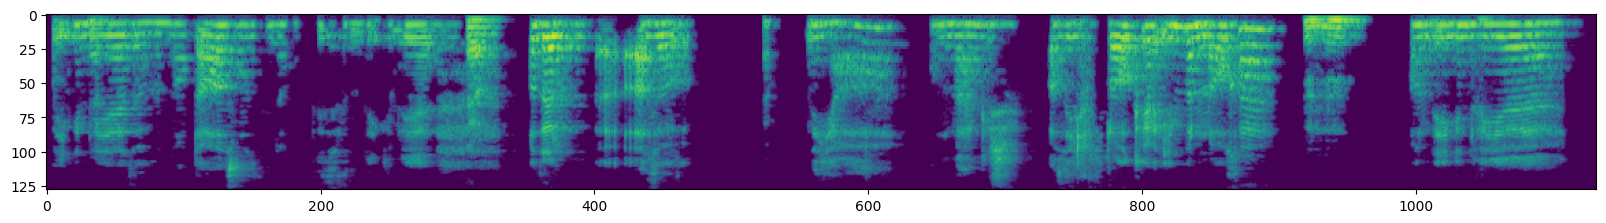

In [311]:
plt.figure(figsize=(20, 15))
plt.imshow(clean_mel)

In [319]:
clean_mel.std(axis=1)

tensor([0.2486, 0.2809, 0.3626, 0.3532, 0.4653, 0.4926, 0.5435, 0.5694, 0.5769,
        0.5673, 0.5316, 0.5140, 0.4417, 0.4676, 0.5261, 0.5120, 0.5916, 0.5412,
        0.5709, 0.4713, 0.4752, 0.4782, 0.4586, 0.5211, 0.5073, 0.5295, 0.5072,
        0.4892, 0.4885, 0.4639, 0.5056, 0.5256, 0.5259, 0.5352, 0.4914, 0.5024,
        0.4419, 0.4632, 0.4623, 0.4373, 0.4727, 0.4331, 0.4728, 0.4534, 0.4375,
        0.4495, 0.4407, 0.4454, 0.4788, 0.4565, 0.4488, 0.4358, 0.4621, 0.4597,
        0.4595, 0.4535, 0.4359, 0.4271, 0.4306, 0.4315, 0.4340, 0.4240, 0.4029,
        0.3925, 0.3937, 0.3934, 0.3855, 0.3895, 0.3924, 0.3981, 0.4077, 0.3999,
        0.3930, 0.3885, 0.3833, 0.3777, 0.3873, 0.3823, 0.3866, 0.3928, 0.4001,
        0.4050, 0.4330, 0.4405, 0.4488, 0.4549, 0.4666, 0.4466, 0.4430, 0.4413,
        0.4048, 0.3784, 0.3581, 0.3536, 0.3617, 0.3646, 0.3785, 0.3859, 0.3868,
        0.3824, 0.3928, 0.3612, 0.3353, 0.3411, 0.3478, 0.3716, 0.3769, 0.3800,
        0.3986, 0.3775, 0.3524, 0.3323, 

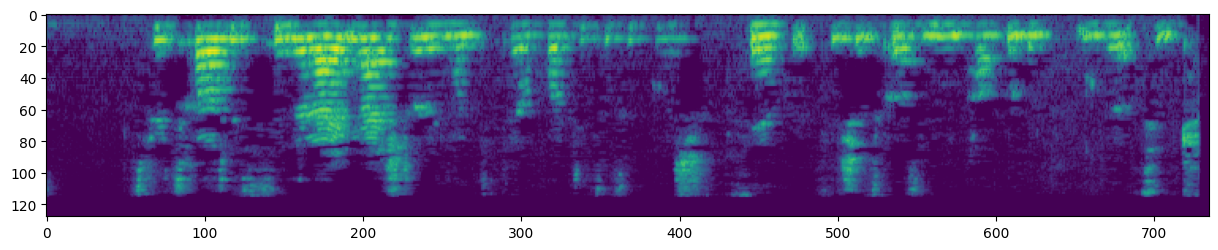

In [312]:
import librosa
therap_a = whisper_log_mel("Therapeutin A 5.m4a")
plt.figure(figsize=(15, 10))
plt.imshow(therap_a)

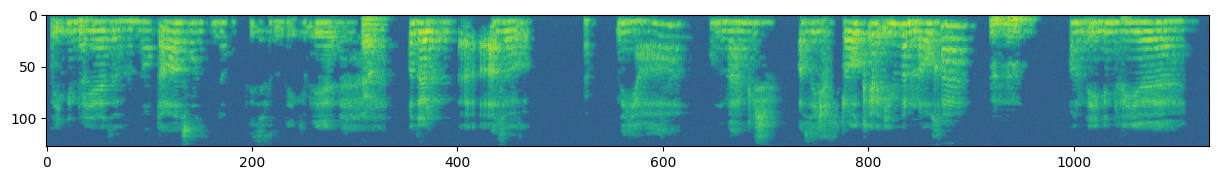

In [306]:
raise_floor = RaiseFloor(          # per-mel target vector
    target_floor=floor_degrad,     # tensor size [80]
    jitter_db=0.1                 # modest wander
)

drop_ridges = DropRidges(
    knee_db=2,       # start compressing ridges >3 dB
    max_drop_db=max_drop_db * 10        # computed from SNR difference
)

mel_aug = drop_ridges( raise_floor(clean_mel) )

plt.figure(figsize=(15, 10))
plt.imshow(mel_aug)

In [321]:
inverse_whisper = inverse_whisper_log_mel(mel_aug)
display(Audio(inverse_whisper, rate=16_000))

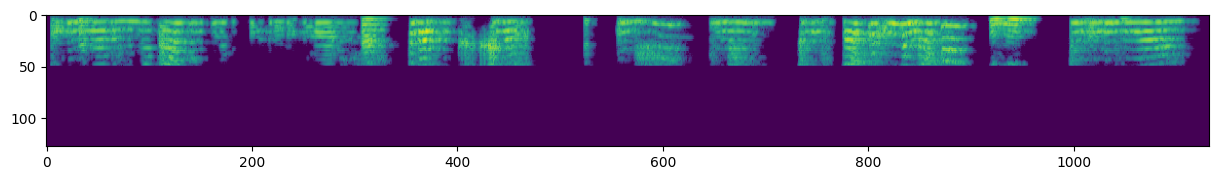

In [371]:
import librosa

therapeut_b_mel = whisper_log_mel("Therapeut B 3.m4a")
therapeut_b_mel[50:, :] = therapeut_b_mel.min()
plt.figure(figsize=(15, 10))
plt.imshow(therapeut_b_mel)
therapeut_b_mel_aud = inverse_whisper_log_mel(therapeut_b_mel)
display(Audio(therapeut_b_mel_aud, rate=16_000))

In [307]:
import librosa
therapeut_b, sr = librosa.load("Therapeutin A 5.m4a", sr=None)  # y is the audio signal, sr is the sampling rate
therapeut_b = librosa.resample(therapeut_b, orig_sr=sr, target_sr=16_000)
display(Audio(therapeut_b, rate=16_000))

/tmp/ipykernel_4018/891299026.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  therapeut_b, sr = librosa.load("Therapeutin A 5.m4a", sr=None)  # y is the audio signal, sr is the sampling rate
/home/kenfus/miniconda3/envs/whisper_finetune/lib/python3.9/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [374]:
import torch

def taper_high_band(mel: torch.Tensor,
                    cut_bin: int = 70,
                    width: int = 20) -> torch.Tensor:
    """
    Linear ramp that drives bins [cut_bin-width … cut_bin-1] down to the
    spectrogram floor, then sets bins ≥ cut_bin to that floor.
    
    * mel: (n_mels, T) — NOT batched                          (Whisper scale)
    * cut_bin: first bin that is fully suppressed             (default 80)
    * width:   #bins over which to taper (linear)             (default 10)
    """
    m = mel.clone()                          # keep original intact
    floor = m.min()                          # Whisper’s hard floor = −1.0

    # 1. build a column vector [0, …, 1] with `width` steps
    ramp = torch.linspace(0., 1., width, device=m.device)[:, None]   # (width,1)

    # 2. linearly interpolate each ramp bin toward the floor
    band = m[cut_bin-width:cut_bin, :]                           # view on data
    m[cut_bin-width:cut_bin, :] = band * (1 - ramp) + floor * ramp

    # 3. brick-wall everything above the cut
    m[cut_bin:, :] = floor
    return m


In [375]:
therapeut_b_mel = whisper_log_mel("Therapeut B 3.m4a")
therapeut_b_mel

tensor([[-0.6623, -0.6623, -0.6623,  ..., -0.6623, -0.6623, -0.6623],
        [-0.6623, -0.6623, -0.6623,  ..., -0.6623, -0.6623, -0.6623],
        [-0.6623, -0.6623, -0.6623,  ..., -0.6623, -0.6623, -0.6623],
        ...,
        [-0.6623, -0.6623, -0.6623,  ..., -0.6623, -0.6623, -0.6623],
        [-0.6623, -0.6623, -0.6623,  ..., -0.6623, -0.6623, -0.6623],
        [-0.6623, -0.6623, -0.6623,  ..., -0.6623, -0.6623, -0.6623]])

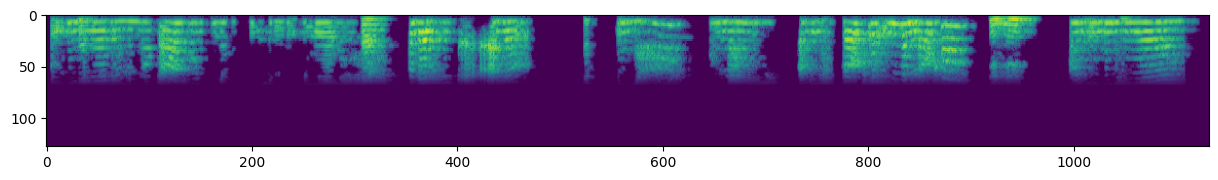

In [376]:
therapeut_b_mel = whisper_log_mel("Therapeut B 3.m4a")
therapeut_b_mel = taper_high_band(therapeut_b_mel)
plt.figure(figsize=(15, 10))
plt.imshow(therapeut_b_mel)
therapeut_b_mel_aud = inverse_whisper_log_mel(therapeut_b_mel)
display(Audio(therapeut_b_mel_aud, rate=16_000))